In [1]:
import regex as re
import collections
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import nltk.tokenize
from nltk.lm.preprocessing import padded_everygram_pipeline
from nltk.lm import MLE, KneserNeyInterpolated

In [2]:
def tokenize(text):
    # Initialise lists
    tokens = []
    
    # since we do not use unmatchable it is commented out 
    # unmatchable = []

    # Compile patterns for speedup
    
    token_pat = re.compile(r'\w+|\p{Emoji}+') # parts of words and emojis
    skippable_pat = re.compile(r'\s+')  # typically spaces
    # Analyze one line at the time as splicing big chunks of text is highly inefficient
    for line in text.split('\n'):
        # As long as there's any material left...
        while line:
            # Try finding a skippable token delimiter first.
            skippable_match = re.search(skippable_pat, line)
            if skippable_match and skippable_match.start() == 0:
                # If there is one at the beginning of the line, just skip it.
                line = line[skippable_match.end():]
            else:
                # Else try finding a real token.
                token_match = re.search(token_pat, line)
                if token_match and token_match.start() == 0:
                    # If there is one at the beginning of the line, tokenise it.
                    if line[:token_match.end()] != 'user': # skipping censored Twitter handles
                        tokens.append(line[:token_match.end()])
                    line = line[token_match.end():]
                    
                else:
                    # Else there is unmatchable material here.
                    # It ends where a skippable or token match starts, or at the end of the line.
                    unmatchable_end = len(line)
                    if skippable_match:
                        unmatchable_end = skippable_match.start()
                    if token_match:
                        unmatchable_end = min(unmatchable_end, token_match.start())
                    # Add it to unmatchable and discard from line.
                    # unmatchable.append(line[:unmatchable_end])
                    line = line[unmatchable_end:]

    return tokens

In [3]:
def freq_plot(tokens, voc, idx):
    
    
    frq = pd.DataFrame(voc.most_common(), columns=['token', 'frequency'])

    # Index in the sorted list
    frq['idx'] = frq.index + 1

    # Frequency normalised by corpus size
    frq['norm_freq'] = frq.frequency / len(tokens)

    # Cumulative normalised frequency
    frq['cumul_frq'] = frq.norm_freq.cumsum()
    
    xlabel = 'Index'
    ylabel = 'Cumulative frequency'
    
    fig, axs = plt.subplots(1, 3,figsize=(12,7))
    
    fig.suptitle(idx) 
    
    # Plot: Cumulative frequency by index
    axs[0].scatter(x='idx', y='cumul_frq', data=frq)
    axs[0].set_xlabel(xlabel)
    axs[0].set_ylabel(ylabel)

    # Plot: Cumulative frequency by index, top 10000 tokens
    axs[1].scatter(x='idx', y='cumul_frq', data=frq[:10000])
    axs[1].set_xlabel(xlabel)
    axs[1].set_ylabel(ylabel)

    # Plot: Log-log plot for Zipf's law
    
    # add zip's law line to the graph 
    frq['log_frq'] = np.log(frq.frequency)
    frq['log_rank'] = np.log(frq.frequency.rank(ascending=False))
    
    axs[2].scatter(x='log_rank', y='log_frq', data=frq)
    axs[2].set_xlabel("log(rank)")
    axs[2].set_ylabel("log(frequency)")

    
    plt.tight_layout()
    
    fig.show()
    

In [27]:
def read_text(path: str):
    val = list()
    text = open(f'../data/{idx}/{path}', 'r', encoding='utf-8').read().splitlines()

    for line in text:
        val += (line.split("."))
    
    
    # tokenisation of data 
    new_val= []
    for i, line in enumerate(val):
        to_add = tokenize(line)
        if to_add:
            new_val.append(to_add)

    val = new_val  
    
    return val

In [4]:
tk = nltk.tokenize.TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)

In [5]:
# each element of this dictionary is a tuple, whose first element is tokens from tokenize()
#and second is from TweetTokenizer()

tokens = dict()
counters = dict()

# indices of the above dictionaries
indices = ['offensive', 'sentiment', 'gatsby']

for idx in indices:
    if idx == 'gatsby':
        # The Great Gatsby has a different path, we also need to remove Gutenberg's header and footer
        text = open('../data/GreatGatsby.txt', 'r', encoding='utf-8').read().split('***')[2]
    else:
        text = open(f'../data/{idx}/train_text.txt', 'r', encoding='utf-8').read()
    tokens[idx] = (tokenize(text), tk.tokenize(text))
    counters[idx] = (collections.Counter(tokens[idx][0]), collections.Counter(tokens[idx][1]))
    
    print(idx.capitalize())
    print('-' * len(idx))
    
    length = len(tokens[idx][0])
    length_counter = len(counters[idx][0])
    print(f"""Our  tokenizer found {length} tokens, {length_counter} of which\
 (or {round(100 * length_counter / length, 2)}%) are unique.""")
    length = len(tokens[idx][1])
    length_counter = len(counters[idx][1])
    print(f"""TweetTokenizer found {length} tokens, {length_counter} of which\
 (or {round(100 * length_counter / length, 2)}%) are unique.\n""")

Offensive
---------
Our  tokenizer found 244967 tokens, 23624 of which (or 9.64%) are unique.
TweetTokenizer found 271264 tokens, 19736 of which (or 7.28%) are unique.

Sentiment
---------
Our  tokenizer found 901635 tokens, 56021 of which (or 6.21%) are unique.
TweetTokenizer found 1015580 tokens, 49124 of which (or 4.84%) are unique.

Gatsby
------
Our  tokenizer found 50004 tokens, 6258 of which (or 12.51%) are unique.
TweetTokenizer found 61266 tokens, 5936 of which (or 9.69%) are unique.



In [6]:
print('20 most common words\n')
for idx in indices:
    print(f'{idx.capitalize()}:')
    for rank, word in enumerate(counters[idx][0].most_common(20), 1):
        print(f'{rank}. {word[0]} - {word[1]} occurences')
    print()

20 most common words

Offensive:
1. the - 7271 occurences
2. is - 5656 occurences
3. to - 5472 occurences
4. # - 4740 occurences
5. a - 4582 occurences
6. and - 4106 occurences
7. you - 3683 occurences
8. of - 3347 occurences
9. are - 3076 occurences
10. I - 3075 occurences
11. that - 2369 occurences
12. in - 2321 occurences
13. s - 2172 occurences
14. for - 2152 occurences
15. t - 2018 occurences
16. it - 1828 occurences
17. he - 1681 occurences
18. on - 1475 occurences
19. she - 1421 occurences
20. with - 1299 occurences

Sentiment:
1. the - 34873 occurences
2. to - 20673 occurences
3. I - 15273 occurences
4. in - 13130 occurences
5. on - 12573 occurences
6. a - 12202 occurences
7. and - 12015 occurences
8. # - 11494 occurences
9. of - 10683 occurences
10. for - 9669 occurences
11. is - 9269 occurences
12. s - 8502 occurences
13. you - 7939 occurences
14. it - 7700 occurences
15. with - 7352 occurences
16. be - 7096 occurences
17. at - 6902 occurences
18. tomorrow - 6664 occurences
1

<ipython-input-3-60ac4ee5c8fd>:43: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


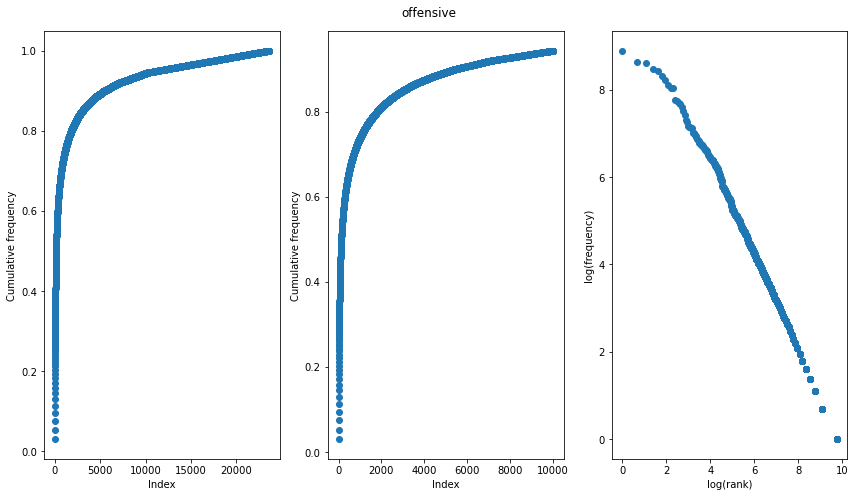

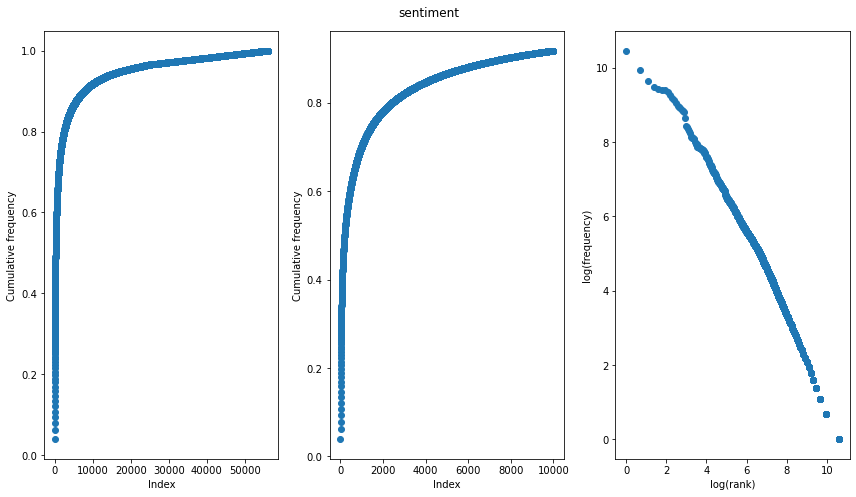

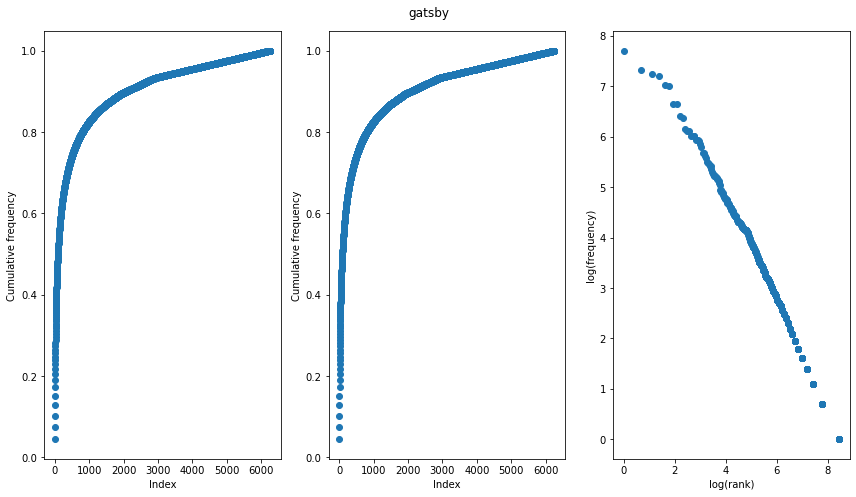

In [7]:
for idx in indices:
    freq_plot(tokens[idx][0], counters[idx][0],idx)


In [8]:
# drop gatsby
if "gatsby" in counters.keys():
    del counters["gatsby"]

if "gatsby" in tokens.keys():
    del tokens["gatsby"]    

indices = ['offensive', 'sentiment']

In [9]:
# drop list at index 1 at all tuples because tweettokenizer generated weird n-grams, for example "!" "!" "!" or "s" "u" "s"

for idx in indices:
    if type(tokens[idx]) == tuple :
        tokens[idx] = tokens[idx][0]
        
    if type(counters[idx]) == tuple :
        counters[idx] = counters[idx][0]
 
    
    

In [10]:
#Compare the most frequent words with a general word list for English
wordfre = pd.read_excel(r'../data/wordFrequency.xlsx', sheet_name='1 lemmas')
fre_words = pd.DataFrame(wordfre, columns= ['lemma'])
print("the most frequent words in general word list for English")
print(fre_words.head(20))
print()

for idx in indices:
    print(f'{idx.capitalize()}:')
    for rank, word in enumerate(counters[idx].most_common(20)):
        print(f'{rank}    {word[0]}')
    print()
        

the most frequent words in general word list for English
   lemma
0    the
1     be
2    and
3      a
4     of
5     to
6     in
7      i
8    you
9     it
10  have
11    to
12  that
13   for
14    do
15    he
16  with
17    on
18  this
19   n't

Offensive:
0    the
1    is
2    to
3    #
4    a
5    and
6    you
7    of
8    are
9    I
10    that
11    in
12    s
13    for
14    t
15    it
16    he
17    on
18    she
19    with

Sentiment:
0    the
1    to
2    I
3    in
4    on
5    a
6    and
7    #
8    of
9    for
10    is
11    s
12    you
13    it
14    with
15    be
16    at
17    tomorrow
18    may
19    that



In [11]:
xd = list(zip(tokens["offensive"], tokens["offensive"][1:]))
collections.Counter(xd).most_common(20)

[(('you', 'are'), 914),
 (('gun', 'control'), 844),
 (('he', 'is'), 823),
 (('she', 'is'), 768),
 (('is', 'a'), 715),
 (('#', 'MAGA'), 662),
 (('don', 't'), 644),
 (('of', 'the'), 590),
 (('He', 'is'), 545),
 (('She', 'is'), 531),
 (('You', 'are'), 483),
 (('in', 'the'), 480),
 (('I', 'm'), 361),
 (('to', 'be'), 346),
 (('is', 'the'), 333),
 (('it', 's'), 332),
 (('It', 's'), 297),
 (('MAGA', '#'), 295),
 (('to', 'the'), 287),
 (('on', 'the'), 284)]

In [12]:
xd = list(zip(tokens["offensive"], tokens["offensive"][1:], tokens["offensive"][2:]))
collections.Counter(xd).most_common(20)

[(('#', 'MAGA', '#'), 291),
 (('I', 'don', 't'), 167),
 (('She', 'is', 'a'), 115),
 (('He', 'is', 'a'), 98),
 (('gun', 'control', 'laws'), 90),
 (('he', 'is', 'a'), 88),
 (('she', 'is', 'a'), 81),
 (('you', 'are', 'a'), 72),
 (('for', 'gun', 'control'), 64),
 (('don', 't', 'know'), 60),
 (('You', 'are', 'a'), 55),
 (('is', 'going', 'to'), 52),
 (('you', 'don', 't'), 51),
 (('they', 'don', 't'), 51),
 (('a', 'lot', 'of'), 50),
 (('on', 'gun', 'control'), 49),
 (('about', 'gun', 'control'), 48),
 (('gun', 'control', 'and'), 48),
 (('don', 't', 'have'), 47),
 (('that', 'you', 'are'), 46)]

In [13]:
xd = list(zip(tokens["offensive"], tokens["offensive"][1:], tokens["offensive"][2:], tokens["offensive"][3:]))
collections.Counter(xd).most_common(20)

[(('#', 'MAGA', '#', 'KAG'), 39),
 (('#', 'TCOT', '#', 'MAGA'), 33),
 (('TCOT', '#', 'MAGA', '#'), 33),
 (('#', 'MAGA', '#', 'RedNationRising'), 33),
 (('I', 'don', 't', 'know'), 28),
 (('❤', '️', '❤', '️'), 26),
 (('MAGA', '#', 'KAG', '#'), 23),
 (('I', 'don', 't', 'think'), 22),
 (('common', 'sense', 'gun', 'control'), 22),
 (('🇺🇸❤', '️', '🇺🇸❤', '️'), 21),
 (('️', '🇺🇸❤', '️', '🇺🇸❤'), 19),
 (('the', 'rest', 'of', 'the'), 18),
 (('#', 'MAGA', '#', 'WWG1WGA'), 17),
 (('️', '❤', '️', '❤'), 17),
 (('when', 'it', 'comes', 'to'), 16),
 (('you', 'are', 'going', 'to'), 15),
 (('nothing', 'to', 'do', 'with'), 15),
 (('is', 'one', 'of', 'the'), 15),
 (('I', 'hope', 'you', 'are'), 14),
 (('don', 't', 'have', 'a'), 14)]

In [14]:
xd = list(zip(tokens["offensive"], tokens["offensive"][1:], tokens["offensive"][2:], tokens["offensive"][3:], tokens["offensive"][4:], tokens["offensive"][5:], tokens["offensive"][6:], tokens["offensive"][7:]))
collections.Counter(xd).most_common(20)

[(('🇺🇸❤', '️', '🇺🇸❤', '️', '🇺🇸❤', '️', '🇺🇸❤', '️'), 15),
 (('️', '🇺🇸❤', '️', '🇺🇸❤', '️', '🇺🇸❤', '️', '🇺🇸❤'), 14),
 (('#', 'Tories', '#', 'Labour', '#', 'GE2017', '#', 'Conservatives'), 9),
 (('Tories',
   '#',
   'Labour',
   '#',
   'GE2017',
   '#',
   'Conservatives',
   'Conservatives'),
  9),
 (('❤', '️', '❤', '️', '❤', '️', '❤', '️'), 8),
 (('🤦🏾', '\u200d', '♂', '️', '🤦🏾', '\u200d', '♂', '️'), 5),
 (('Looks', 'Like', 'The', 'Jokes', 'On', 'Liberals', 'Again', '#'), 5),
 (('Like', 'The', 'Jokes', 'On', 'Liberals', 'Again', '#', 'FortTrump'), 5),
 (('The', 'Jokes', 'On', 'Liberals', 'Again', '#', 'FortTrump', '#'), 5),
 (('Jokes', 'On', 'Liberals', 'Again', '#', 'FortTrump', '#', 'Poland'), 5),
 (('On', 'Liberals', 'Again', '#', 'FortTrump', '#', 'Poland', '#'), 5),
 (('Liberals',
   'Again',
   '#',
   'FortTrump',
   '#',
   'Poland',
   '#',
   'BoomingEconomy'),
  5),
 (('ANTIFA', 'with', 'their', 'KKK', 'hoods', 'beating', 'up', 'strangers'),
  5),
 (('with', 'their', 'KKK', '

In [15]:
sentences = list()
text = open(f'../data/{idx}/train_text.txt', 'r', encoding='utf-8').read().splitlines()


In [16]:
for line in text:
    sentences += (line.split("."))

In [17]:
text[1]

'"Ben Smith / Smith (concussion) remains out of the lineup Thursday, Curtis #NHL #SJ" '

In [18]:
sentences[0]

'"QT @user In the original draft of the 7th book, Remus Lupin survived the Battle of Hogwarts'

## data clearing 

In [19]:
new_sentences = []
for i, line in enumerate(sentences):
    to_add = tokenize(line)
    if to_add:
        new_sentences.append(to_add)

sentences = new_sentences

In [20]:
sentences

[['QT',
  'In',
  'the',
  'original',
  'draft',
  'of',
  'the',
  '7th',
  'book',
  'Remus',
  'Lupin',
  'survived',
  'the',
  'Battle',
  'of',
  'Hogwarts'],
 ['#', 'HappyBirthdayRemusLupin'],
 ['Ben',
  'Smith',
  'Smith',
  'concussion',
  'remains',
  'out',
  'of',
  'the',
  'lineup',
  'Thursday',
  'Curtis',
  '#',
  'NHL',
  '#',
  'SJ'],
 ['Sorry',
  'bout',
  'the',
  'stream',
  'last',
  'night',
  'I',
  'crashed',
  'out',
  'but',
  'will',
  'be',
  'on',
  'tonight',
  'for',
  'sure'],
 ['Then', 'back', 'to', 'Minecraft', 'in', 'pc', 'tomorrow', 'night'],
 ['Chase',
  'Headley',
  's',
  'RBI',
  'double',
  'in',
  'the',
  '8th',
  'inning',
  'off',
  'David',
  'Price',
  'snapped',
  'a',
  'Yankees',
  'streak',
  'of',
  '33',
  'consecutive',
  'scoreless',
  'innings',
  'against',
  'Blue',
  'Jays'],
 ['Alciato',
  'Bee',
  'will',
  'invest',
  '150',
  'million',
  'in',
  'January',
  'another',
  '200',
  'in',
  'the',
  'Summer',
  'and',
  'p

In [21]:
sentences[0]

['QT',
 'In',
 'the',
 'original',
 'draft',
 'of',
 'the',
 '7th',
 'book',
 'Remus',
 'Lupin',
 'survived',
 'the',
 'Battle',
 'of',
 'Hogwarts']

## Max. likelihood evaluation classifier 

In [34]:
lm = [None, None]
for i in range(2, 4): # chnaged 7 to 4
    lm.append(MLE(i))
    train, vocab = padded_everygram_pipeline(i, sentences)
    lm[i].fit(train, vocab)
    print(f'{i}\n---')
    print(lm[i].generate(10))

2
---
['Monday', '30', 'pm', 'until', 'april', 'huff', 'socks', 'with', 'Android', '</s>']
3
---
['want', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>']


In [35]:
print(lm[2].score("car",["the"]))
print(lm[2].score("Trump",["is"]))

print(lm[2].logscore("car",["the"]))
print(lm[2].logscore("Trump",["is"]))

0.0006021850715453216
0.00010788650339842486
-10.697505436140611
-13.178197984584981


In [36]:
val = read_text("val_text.txt")

In [37]:
# it does not work properly or is just confuding, ask TA about this part of code 
for i in range(2, 4): # changed 7 to 4 
    val_test, _ = padded_everygram_pipeline(i, val)
    for n, t in enumerate(val_test):
        print(lm[i].perplexity(t))
        

inf
inf
100.09497140075896
inf
inf
inf
inf
inf
inf
132.44023549931347
inf
inf
156.96142021666026
inf
inf
inf
inf
inf
inf
151.30143595899648
inf
181.1873853119585
inf
113.66163039439718
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
112.93134610676786
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
293.3885614286094
inf
107.29177806580451
inf
412.2706793296604
34.143818870492034
121.82738286165241
216.9576643503375
inf
inf
inf
223.6175298967453
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
210.86697437545348
inf
inf
inf
inf
246.40970534362032
inf
inf
inf
174.92886797613093
inf
inf
inf
94.78521872070058
inf
inf
inf
inf
inf
66.46897726008437
inf
inf
inf
inf
91.31286412169565
inf
inf
inf
inf
106.42325056924082
inf
inf
inf
inf
inf
inf
inf
inf
inf
76.3969936669264
inf
inf
inf
inf
inf
76.89874984751118
inf
165.615880866295
inf
inf
inf
inf
inf
157.0983192203514
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
445.3886043123691
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
245.41346

inf
inf
inf
inf
99.5580007000303
inf
69.08995948044137
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
82.94001118494589
inf
254.79067959819966
inf
115.75422246229256
inf
146.83294039421068
inf
inf
inf
inf
inf
inf
inf
inf
inf
227.08132428620794
inf
inf
inf
inf
inf
inf
inf
inf
250.64859012500605
inf
inf
inf
inf
95.25441889940139
inf
150.1638110136953
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
160.10810036954408
inf
inf
inf
inf
100.84337790454781
inf
inf
177.5599008795389
72.67713394646924
inf
58.72897725664503
inf
117.35178998162422
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
87.63115462010093
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
164.19670908057387
inf
inf
inf
inf
inf
inf
inf
303.6983510279236
inf
inf
inf
inf
inf
inf
inf
163.38452453246478
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
178.15825244652916
inf
163.8264318603017
inf
inf
inf
inf
inf
in

inf
inf
inf
inf
117.6845118881342
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
92.03050627502846
inf
inf
inf
inf
inf
inf
inf
98.19070957768538
inf
inf
inf
inf
291.6691057561747
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
273.3760241129866
290.98619140607394
inf
inf
inf
inf
123.43878749215739
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
288.7275716066486
inf
inf
213.08963833057692
inf
inf
inf
inf
inf
611.264303653072
435.68849094963974
300.15038021505194
inf
254.6548106474982
inf
inf
inf
inf
inf
inf
inf
99.42441170851022
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
81.76762082046913
inf
inf
inf
108.26987954391569
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
166.24375298906762
inf
inf
221.24264407909752
inf
inf
inf
inf
125.01296218818062
168.88821774993323
inf
inf
208.33588872471842
128.152154532516
inf
486.58339928378683
inf
inf
inf
inf
150.0305779662768
inf
inf
134.70243157939433
inf
inf
inf
219

inf
inf
38.48920757308917
inf
inf
inf
inf
inf
inf
inf
inf
19.664688191201954
inf
16.49006674277478
inf
36.85553296626529
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
18.383797401923616
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
74.4086625454019
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
18.378522466187377
inf
inf
inf
inf
inf
inf
inf
inf
inf
36.5364802452815
inf
inf
inf
inf
inf
inf
inf
inf
inf
47.60716034376149
38.55133758138407
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf

## KneserNeyInterpolated classifier

In [38]:
text = read_text("train_text.txt")

In [39]:
lm = [None, None]
for i in range(2, 4):
    lm.append(KneserNeyInterpolated(i))
    train, vocab = padded_everygram_pipeline(i, text)
    lm[i].fit(train, vocab)
    print(f'{i}\n---')
    print(lm[i].generate(10))

2
---
['della', 'Strada', '</s>', 'Yearly', 'Visit', 'Pope', 's', 'getting', 'late', 'in']
3
---
['andalsoPanera', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>']


In [40]:
print(lm[2].score("car",["the"]))
print(lm[2].score("Trump",["is"]))

print(lm[2].logscore("car",["the"]))
print(lm[2].logscore("Trump",["is"]))

0.0005997174775295596
9.745295571506299e-05
-10.703429361760255
-13.32493453183926


In [41]:
val = read_text("val_text.txt")

In [42]:
for i in range(2, 4): # changed 7 to 4 
    val_test, _ = padded_everygram_pipeline(i, val)
    for n, t in enumerate(val_test):
        print(lm[i].perplexity(t))

15183.620427253563
20584.038860229055
1825.8086597475358
17248.34030070176
9942.450512201598
3723.716908175081
8765.80968539938
12134.867845574137
6627.785296176272
2667.538715677291
6251.581720161914
19411.366089792962
1945.589978042895
7843.567493480712
5788.239445772951
4629.712277282682
6207.209759807761
5038.5332845635185
8179.291905395279
5196.317885097839
8176.6964805663765
4693.1863664426355
27913.453403513337
2423.767099911213
6543.78269903566
4752.9287249957415
15917.950580139393
5582.030124239388
3434.544407618467
5971.565205528996
54715.752558652464
11546.013742184363
4557.01876280537
8040.153025594786
11085.407962749428
1952.1664322311433
2995.1636541591083
2673.6487048686263
27172.91647355048
3785.2812449242615
6286.761389899589
2936.080001960725
12134.170985302368
25219.330502940556
7494.345753960171
34928.0351619603
7011.216272316298
11870.558354066556
12214.084977151628
16043.699474234825
18804.817568338603
3466.1928556761404
9586.818312467287
21820.534557271894
4459.7

7925.209419271181
12415.643703094102
26405.816192351595
5077.200221906003
4251.783578125123
12432.913947801735
27759.466096600543
4151.485926287959
12218.515554239135
6381.617847438356
12764.542335031745
25283.02641874649
12262.389249950687
4457.713623898607
1711.3469766544852
36352.72829403603
15881.264080931196
6937.834055410628
4882.608034512122
2780.4281672566585
1761.599218442886
10231.399125329119
19293.8714452645
23464.247754653366
8846.365820058056
3305.004273170837
7955.472321809231
4931.302893556192
11124.96691864012
3122.0079342525028
3847.985492540714
17794.940159242018
3907.4534130334764
14160.96036779392
9840.196421493165
225376.30914921607
4354.022882387066
3016.894740390122
14427.59147526875
2350.916221410849
4328.317384557586
6401.687377527858
1876.708143281256
5820.329590922325
6236.73186934395
2166.4569681206217
2641.8499190065186
17194.83315512996
8244.445611504883
13580.27101265394
6376.952539559893
4150.952968961438
23716.428844684648
31619.048590858558
2666.11487

27321.61054326951
5490.385607287879
24641.24232767973
3398.4396451098883
10933.467660196546
16436.664933535456
19598.791299091707
13372.561441313665
6787.972484831197
19730.594503582444
9828.175815985747
8199.278048465236
17670.86802082243
7106.369614202785
7892.129399609335
3316.188401636698
1787.6948906311143
6638.394341007794
27032.911174339082
26898.982213661046
19928.576106026358
16725.75891251184
3384.0483094633137
8289.61555881527
15602.049346180598
2217.738403269408
3611.439132344721
1656.4118151515338
2165.6300599016636
6522.431368528893
7520.499573100155
6814.564647632991
7004.567418642533
6019.904074147799
7332.155649083012
8115.931557058499
5890.799055383307
6897.907556503877
3487.614116212731
1512.6616428093012
2596.544782007262
12021.150199279404
9913.085142516631
20927.88198273301
2055.591016528353
2792.266346174384
43459.2567176164
14337.738096941346
4037.866519839136
5690.320374554646
11443.294530914414
5351.948262071977
5986.875743110111
6648.969709144169
4516.4479512

24309.586947711392
1976.678133506247
2730.8733298145703
59861.00387561605
9580.829509004741
21486.996361260448
15235.66512539953
3103.475607461538
8071.713483593231
2079.5153269822067
3087.862438023577
41176.09111822296
13010.037654341753
11003.711789981957
4613.165785522473
29477.968941626914
6562.552146164482
3383.4571567101293
9344.283669679013
7223.399949639166
4043.622902923011
18288.39221588849
3561.5963480916025
8204.569562709827
24957.722069168296
15229.985749053132
10079.004707214313
16848.44490284264
4407.926112044171
14877.494745758198
11710.59881814553
10069.18475398576
3790.311811325996
2653.360068934249
4128.1994726980465
18208.06081686934
2400.3002021916436
20666.451543763884
3776.277834858038
13917.18636841626
7138.399948720841
3912.6129204686463
8996.697119422504
49472.57545617483
2716.9545323245443
7027.5716741188435
2639.330685942405
31286.920498824587
53896.513243170746
12696.71493583424
20333.67209410809
6153.35010368467
16389.650388943515
2763.3859232737727
7534.1

11377.38308227251
29474.316094967126
6440.626042300773
27341.203918667874
27032.911174339082
7345.992979256451
10758.965846214669
17872.08970115633
5792.841913387257
5758.238677610458
11450.530633113625
2812.6545093195045
4484.986132094294
8139.404524426781
17670.86802082243
21700.26728238764
7892.129399609335
14807.720469138168
28748.59060711395
23252.05944022778
39840.15632263369
6245.186932023428
6374.148516029159
84644.51956383331
5116.156738453752
18253.594662176372
31136.87897343196
29839.402072656478
89672.43700390906
11127.651901384714
5254.187995816804
6841.028113357372
28013.11833318887
56898.04120803963
6559.742661660302
1723.9875526963208
27032.911174339082
4633.070901634394
11131.045379027259
10601.99562063159
6507.4459011963
9938.713422698962
6124.492728233871
6259.118620502103
4983.3288450847995
30388.83162733787
12044.03152591601
2959.398667995776
131126.36152113625
3820.209041594963
8046.649121210585
10074.753384496073
12616.099890910216
14059.326099834501
21432.472223

11989.091475564694
15812.14166022667
2919.5919378714198
4169.682634161323
15009.018890263571
7100.6116280732185
2693.503305370408
5456.509146572588
2776.2812259532834
7158.4969682787
2893.2260812833088
11637.269504352831
10282.112044574715
11383.432754649524
26053.843195684425
24611.99140799474
9947.115005333544
4930.65190995039
4073.2934161339076
9655.493271954983
5506.445190555013
1780.1027321806375
18551.53667236831
9580.896283072218
9233.002226453751
11368.99197633114
15218.792604299982
6139.002290114025
8791.156989228337
23898.80279236783
8394.506183803804
47107.38430625865
4407.434860977949
11854.898188044117
14389.545068729025
41497.759039112294
13718.874890394192
18810.86134312247
4478.789825522418
2642.122536128033
15380.08031580459
6420.518997267813
17098.110137090644
1790.7852829870008
2351.985609361329
8665.056888479281
3661.4949416724444
38331.76312198518
22410.340751998127
21327.91991376822
7014.012694822959
43872.640835714774
108771.9686835069
9481.321119435923
14081.510

7573.153213381509
3714.2162912169265
7137.884801568558
12751.954320844394
2281.37842070438
24606.29772329356
7586.354367141564
4345.246110532207
2374.378866761669
6655.414080316535
25328.269499900216
76515.56798984417
50230.21609511961
39555.398079617866
5339.063772612911
25622.74050812916
48789.071092171354
15383.200074716204
11937.241011694843
131126.36152113625
11435.782467481931
70027.83046022567
8385.97471183404
10682.54082767807
27032.911174339082
9091.980405190445
4485.618282288188
9502.742800712726
4531.668800595615
12904.93972496083
12432.553307738335
4317.485260969621
2612.6887333805316
14542.37058802737
5385.447465758996
13171.415613856314
3127.6252612857834
19051.746974324848
17836.20612638932
9564.768990466853
8226.71581895241
5670.545861463812
6981.518196322641
7840.535048757348
18914.676883504355
30388.994292272724
38983.46913001713
5084.049159240791
71218.98364402159
3643.330679138306
3374.1496830973156
22386.065962151057
3129.4998040628498
3813.7254866489247
22313.4339

4107.887162998298
780.8270221047136
2483.548810972488
1220.5275059573257
505.3603069497847
3002.9447147493006
3563.353958516374
4809.728672158179
609.8854206980039
2470.2189606147535
5230.894325642646
1520.5236305719322
10075.571975601282
3557.7579995782908
306.7558388878322
2035.2529661187916
507.6872626896743
970.5959447040794
18401.059769848147
11484.669039539029
1082.7128917389637
2005.8383111579033
650.7756577010751
811.1642905257403
824.6599228978397
2716.823879874695
14290.494591419148
11000.29501368856
15336.05190482064
4163.55778297764
14308.231714834737
3187.017449162114
1030.29277513974
2897.2961004007066
11906.6547884381
6632.669441050733
247.30896182719272
2534.2132779473304
6673.578851243153
2539.3351570909185
6129.352450259115
2124.320884357166
2224.4549546620187
1571.953852419154
19651.291217443017
8439.394501105835
5275.3025389194445
1536.524054990481
4157.676600422804
3483.720287480246
8914.210239345839
1789.024719323611
703.4813492175001
1092.5832852482329
6450.34406

2090.926731633835
3695.0106968762557
10491.070903677637
2971.0258512826313
5833.792103743476
489.35629607088663
3059.9931134214767
2068.803380699888
3393.455499692678
5692.8201565569825
3516.9662811124513
611.3881474357318
5300.080910591194
6725.541020211991
3006.606095924093
2565.4701580620886
907.7765173033022
13947.648117214747
2214.754960627679
9587.711596398656
538.6060706615851
6530.408715899326
846.4515974766108
3155.257246274731
7379.507020337046
3541.309579908786
638.1013807670055
1795.9270441571866
24123.323134175553
4332.496203021831
12226.540638742466
332.6954404161645
6290.819425283769
6304.824971640487
1190.6747212206694
516.7133396643416
9117.124233547469
1349.556236508061
463.95524111845606
6968.140959509234
3407.862819815938
542.817775693973
476.92951643292696
1356.6233210514451
6007.881841045684
14691.003792573774
19162.85016756861
8680.090722489822
15052.799454345517
817.072014927578
366.3932459412484
7364.510141136618
2761.262847649704
8705.158502889843
2371.3800954

12272.107674080577
599.8892308697767
5471.429136027836
1402.7320936786873
2489.738453189826
456.236619699502
7078.9675554905025
2090.7372999362055
4860.510613048657
6087.798607059706
3824.9041978138575
1027.372108642878
4466.265438588557
297.13312118790043
804.0276355731338
3290.9021857071666
4353.747949501307
1376.1885911218596
1417.0752999867
3770.9086085341455
2022.2924154658233
1022.0484241733983
4448.261880741368
6351.712561914497
1663.8873588542601
11479.229844573825
2667.6595504502816
1397.9951499913254
15339.7556770421
891.1382109589041
3997.2855720751622
6339.977236745403
13974.626377165961
7836.238294075993
2781.366249644658
3603.817629169621
1495.5469913393508
5218.727420143055
576.883075919516
737.446235897995
638.6928007838411
21147.76120178398
279.6910600018683
5565.723107452963
4157.676600422804
8121.664498708231
2691.2790237187587
5851.085663976382
4207.894250739495
2007.2678682756625
1137.9089141394006
14622.889150914703
7477.727690641632
2138.891484746579
12536.496083

7652.564430858393
629.6335463132701
2604.258413704793
1840.9752602032138
510.6540682877646
2692.5277409238306
7533.266699272713
1718.7326016521304
12536.496083459073
4097.339662026043
288.66984193597193
1204.7545871530663
1357.387017312897
2358.013889547637
1438.6376663699853
1874.4667196526511
1272.0789170244952
3438.779233754547
6552.678442975334
3956.09938961944
326.74208683412377
963.9993151608877
22396.26514295219
1972.3838100324156
13667.269128244754
533.2093060861812
4157.676600422804
4833.28688957247
2138.735362978455
7414.792360887805
8645.291944786793
2254.663040766079
9150.092295351515
284.38901740064625
1199.9663346316445
23039.428497997014
1124.8304128927357
5332.518733602098
4721.063615587049
2808.2734212229234
2032.9791005930479
2839.095669349773
11422.76913454105
20288.92095305031
2474.7185782855136
1991.557972211775
9425.18017105731
5040.494854831736
336.95811039284547
1084.1373875971278
5892.940714350956
13124.43371310015
14083.566547183764
829.070206392505
3655.14623

1727.5989321858772
8574.497187601515
4879.8180295620705
1189.094615986698
12536.496083459073
1620.8966006597884
3748.0658207734004
4581.061225159476
7432.820776008106
8035.675766871297
14299.407153300377
7008.847756733616
28774.200859204426
13563.979311819427
1084.97806328609
17656.569953458882
786.6134011443093
4991.284911530422
2183.0485066679857
2974.899118569531
424.99333501451565
3212.816821873115
7463.770339863436
401.8457820880692
9092.02641249826
15773.652900143095
3639.18021393498
2279.6785170636736
2666.885668849927
1256.8748121260899
15906.770924782524
325.3176063782412
6777.720897283777
914.1284267142056
1288.6966239236297
6862.905289937199
371.538587695691
398.07946706373974
3426.4544048501525
3078.531626774851
348.87143726182904
2354.987792392799
2190.0614389925104
20972.473153718478
8333.4899607394
8590.065677339988
4584.390877950335
18250.037503789485
371.3441797001724
2200.644708441428
5768.8075304197255
843.1600415249807
2171.8676612380345
722.0507866814638
842.476446

1108.295716536899
6740.22041438553
9336.444038951113
381.7161951591002
1803.1878164710176
6410.028324392669
2674.815163133145
875.3015228282784
2078.1717003860417
786.326691730191
2502.761665917306
910.1810933527246
6798.53149927852
5661.485450284104
5297.657921332735
12163.43454331759
3910.527310279004
3786.8719752197026
1948.6622218215973
470.8562553176086
5213.342033595005
583.0166108366161
291.34323332117066
5595.744433125681
2340.376324531714
4185.613630913308
1983.0797815279059
5845.545612799338
2895.9794111528972
5036.3194680527995
10831.018165453812
3832.0638797592715
20960.53146832055
1089.4025507735407
2382.0233796576904
8714.63260159074
30396.34163015559
7964.979003554864
9184.465275874783
1315.6676865543845
473.4681657212072
2489.1151403923163
2543.5384374198675
9376.06683892171
671.8656724089693
566.2639640078031
3109.745548141972
1146.5413364487738
15696.33186157524
15319.248094713226
15183.185117334599
3260.0860757354994
7636.660317137758
94720.41914234898
4702.684427043

957.5525182296884
472.4909397617593
13060.730785936083
5205.520011342449
3451.017596448759
18139.15870722884
595.6979089000271
899.978172110545
2318.588523964692
539.149582978326
288.98834261870667
5002.920822640656
12068.908304146715
4818.029910537238
1559.8346573001666
2911.482269620333
7925.188195618957
4644.1532214082945
2789.183821699842
1293.2443463604059
3266.062904070679
5311.719827912931
476.9976176675544
19414.273942237473
3143.9745664056727
1409.9096587676547
687.9357901724209
1403.576121265524
12042.760974963696
49099.66512795701
30314.236485893147
9670.606348218456
574.8485496050729
12967.940115642356
18357.57091053853
8704.03182184777
5893.925189750656
12536.496083459073
5545.432557362109
10362.839184449014
3456.145398234004
4622.844441740016
4157.676600422804
4907.18242214383
1319.2787306980374
4719.437804938733
1867.3647032242575
5086.153966589567
4190.486889720907
698.7277394104455
618.7871705744782
7084.881347309155
1428.5748577533825
6899.372591144374
973.21512029587

In [ ]:
# choose some words, calculate for them perplexity in both models and compare them to each other, e.g. attempt to explain such perplexity score was achieved